# Figures S1-2. Comparisons of Jiusti dataset to GlassNet training data

Make sure environment is using `glasspy 0.5.0`, currently available in the `dev` branch of [`glasspy`](https://github.com/drcassar/glasspy).

The Jiusti dataset comes from Table 2 of [Which glass stability parameters can assess the glass-forming ability of oxide systems?](https://ceramics.onlinelibrary.wiley.com/doi/abs/10.1111/ijag.15416)

In [1]:
from glasspy.predict.models import GlassNet
from glasspy.data import SciGlass, sciglass_dbinfo

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau, zscore
from scipy.constants import pi
import seaborn as sns
import pandas as pd
import numpy as np

from utils import get_gs, get_gfa, get_eta_tl

In [2]:
myrcparams = {
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

In [3]:
cols = ['Tg', 'Tc', 'Tx', 'Tliq', 'T_Umax', 'log_Umax']
titles = ['$T_g$', '$T_c$', '$T_x$', '$T_l$', '$T_{max(U)}$', '$log(U_{max})$']

# Data

## Load GlassNet training and test data

In [4]:
glassnet_stnn = GlassNet()
glassnet_train_df = glassnet_stnn.get_training_dataset()
glassnet_test_df = glassnet_stnn.get_test_dataset()

In [5]:
X_glassnet_test = glassnet_test_df.elements
X_glassnet_train = glassnet_train_df.elements
X_glassnet_total = pd.concat( (X_glassnet_train, X_glassnet_test) )

In [6]:
X_glassnet_feats_test, feats = glassnet_stnn.featurizer(X_glassnet_test, return_cols = True)
X_glassnet_feats_train, feats = glassnet_stnn.featurizer(X_glassnet_train, return_cols = True)

In [7]:
X_glassnet_feats_test = pd.DataFrame(X_glassnet_feats_test, columns = feats)
X_glassnet_feats_train = pd.DataFrame(X_glassnet_feats_train, columns = feats)

In [8]:
X_glassnet_feats_test.index = X_glassnet_test.index
X_glassnet_feats_train.index = X_glassnet_train.index

In [9]:
y_glassnet_test = glassnet_test_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_train = glassnet_train_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_total = pd.concat( (y_glassnet_train, y_glassnet_test) )

## Load Jiusti data

In [10]:
benchmark_df = pd.read_csv('../data/jiusti.csv',sep=";") # Table 2
benchmark_df.rename(columns={'Tg (K)': 'Tg', 'Tx (K)': 'Tx', 'Tc (K)': 'Tc', 'Tl (K)': 'Tliq', 'T(Umax) (K)': 'T_Umax',
                             'Umax (m s−1)': 'Umax'}, inplace=True)
benchmark_df['log10 (η∞)'] = benchmark_df['log10 (η∞)'].str.replace('−', '-').astype('float')
benchmark_titles_temps = [r'$T_g$', r'$T_x$', r'$T_c$', r'$T_l$', r'$T_{Umax}$', r'$T_{12}$']
benchmark_df['ViscosityAtTl'] = get_eta_tl(benchmark_df)
benchmark_df['log_Umax'] = np.log( benchmark_df.Umax.str.replace('E', 'e').str.replace('−', '-').values.astype(float) )

# Figure S1

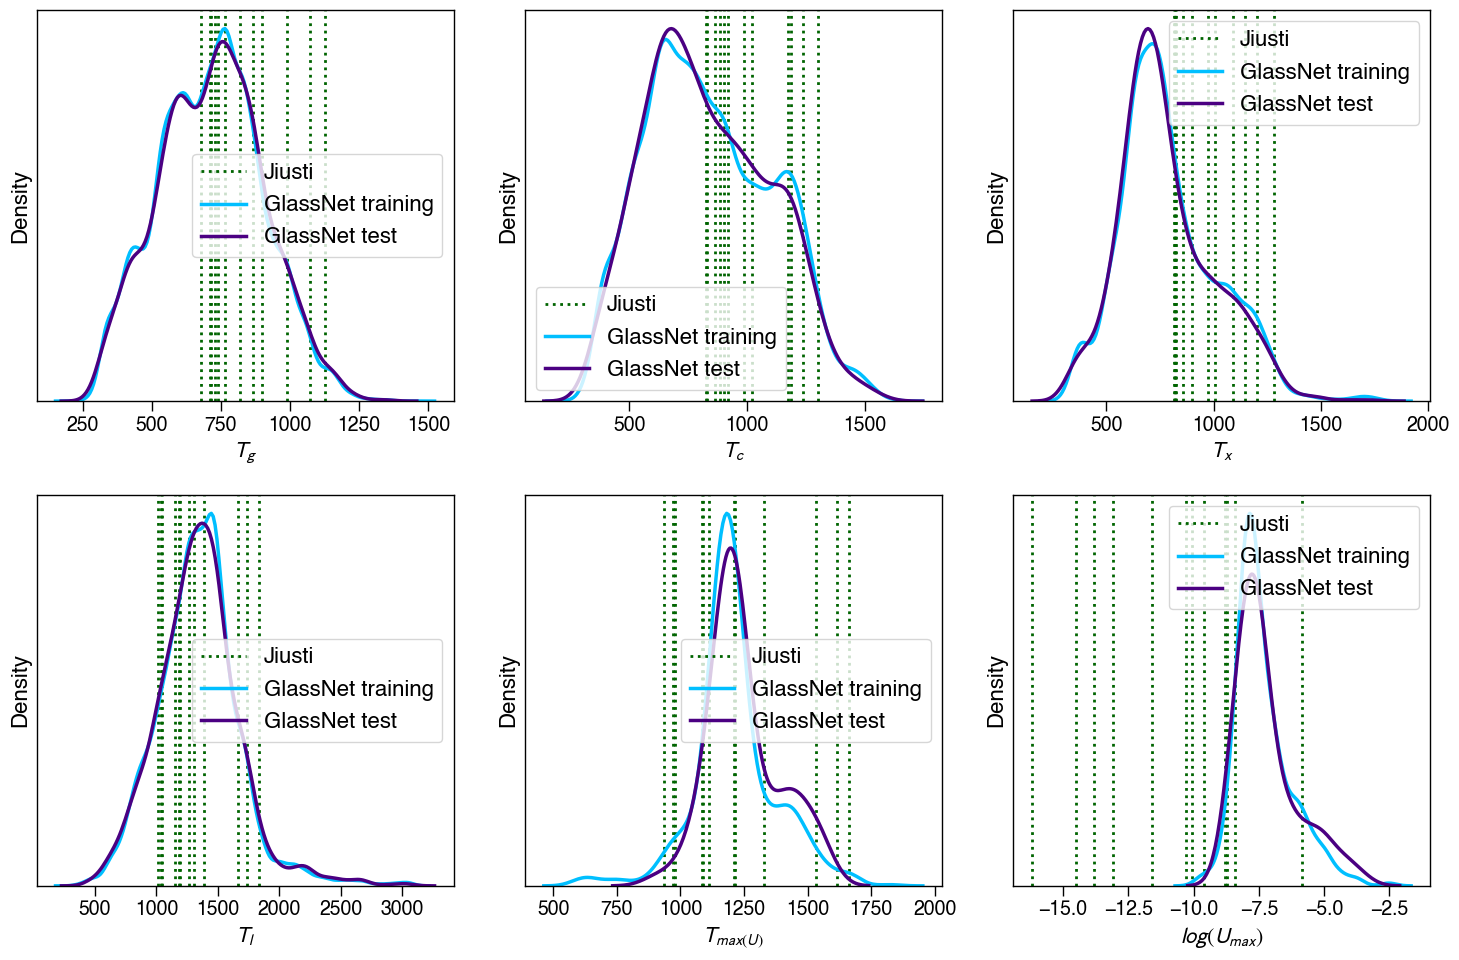

In [11]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
for i,col in enumerate(cols):
    y_train = y_glassnet_train[col].dropna()
    y_test = y_glassnet_test[col].dropna()
    y_benchmark = benchmark_df[col]

    ax = axes[ i // 3, i % 3 ]

    for j,value in enumerate(y_benchmark.values):
        if j == 0:
            ax.axvline( value, color='darkgreen', linestyle='dotted', linewidth=2.0, label='Jiusti' )
        else:
            ax.axvline( value, color='darkgreen', linestyle='dotted', linewidth=2.0 )       
    
    sns.kdeplot( y_train, ax = ax, color='deepskyblue', linewidth=2.5, label = 'GlassNet training' )
    sns.kdeplot( y_test, ax = ax, color='indigo', linewidth=2.5, label = 'GlassNet test'  )
    ax.legend()
    ax.set_xlabel( titles[i] )
    ax.set_yticks([])
    ax.set_yticklabels([])
fig.savefig( 'figureS1.png', dpi=600 )

# Figure S2

In [12]:
benchmark_glassnet_feats =  pd.concat( [ pd.DataFrame( glassnet_stnn.featurizer(comp), columns=feats) for comp in benchmark_df.Glass ] ).reset_index(drop=True)

In [13]:
y_pred_benchmark_stnn = pd.concat( [ glassnet_stnn.predict(comp) for comp in benchmark_df.Glass ] ).reset_index(drop=True).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})

In [14]:
y_pred_glassnet_stnn = glassnet_stnn.predict( X_glassnet_test ).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})

In [15]:
y_pred_glassnet_stnn.index = y_glassnet_test.index

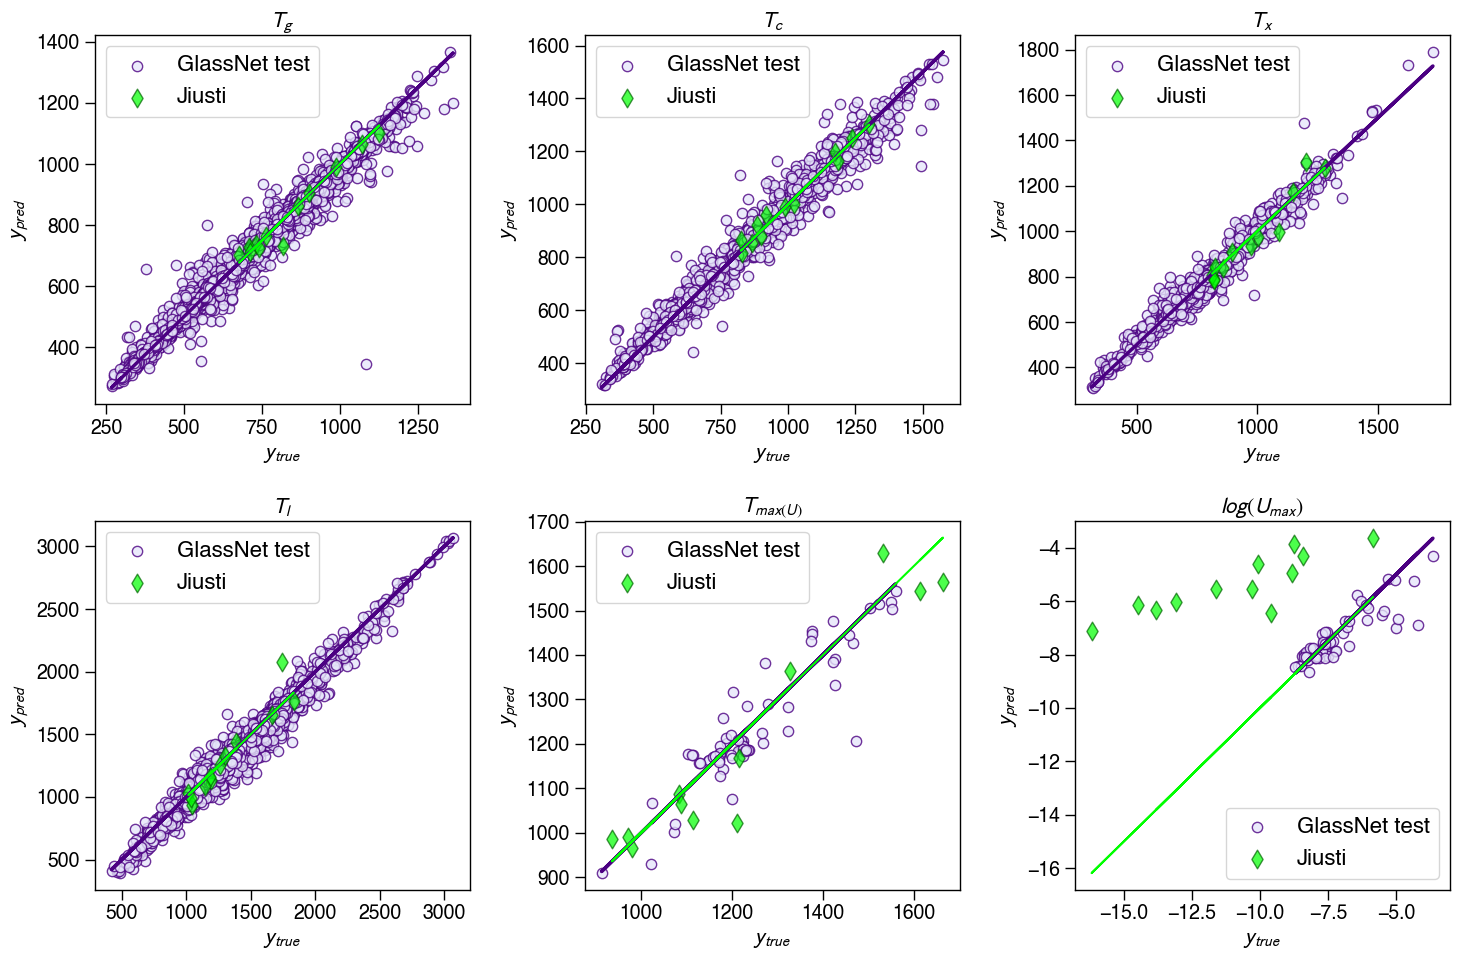

In [16]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
for i,col in enumerate(cols):
    this_y_glassnet_true = y_glassnet_test[col].dropna()
    this_y_pred_glassnet = y_pred_glassnet_stnn.loc[this_y_glassnet_true.index, col]
    this_y_benchmark_true = benchmark_df[col]
    this_y_pred_benchmark = y_pred_benchmark_stnn[col]
    ax = axes[ i // 3, i % 3 ]
    ax.scatter(this_y_glassnet_true, this_y_pred_glassnet, marker='o', s=55, alpha=0.8, color='lavender', edgecolor='indigo', label='GlassNet test')
    ax.plot( this_y_glassnet_true, this_y_glassnet_true, color='indigo', linewidth=2.5)
    ax.scatter(this_y_benchmark_true, this_y_pred_benchmark, marker='d', s=90, alpha=0.7, color='lime', edgecolor='darkgreen', label='Jiusti' )
    ax.plot( this_y_benchmark_true, this_y_benchmark_true, color='lime')
    ax.set_xlabel(r'$y_{true}$')
    ax.set_ylabel(r'$y_{pred}$')
    ax.set_title(titles[i])
    ax.legend()
fig.savefig('figureS2.png', dpi=600)